# Text Summarization

## Import libraries and datasets

In [1]:
import os
import string
import random
import re
import time
import math
import unicodedata

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import nltk
from nltk.corpus import stopwords
from __future__ import unicode_literals, print_function, division
from io import open

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nltk.download('stopwords')

Version 1.13.0+cu116
CUDA enabled: True


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Get the datasets
if not os.path.exists('data'):
  !mkdir data

if not os.path.exists('/root/.kaggle'):
  !mkdir /root/.kaggle
  !echo '{"username":"wjtan428","key":"05f8a59f12b5bfd9a2ad4ab4dffd3b4d"}' > /root/.kaggle/kaggle.json

if not os.path.exists('news-summary.zip'):
  !kaggle datasets download -d sunnysai12345/news-summary

!unzip -n news-summary.zip -d data/
!ls data/

 91% 18.0M/19.8M [00:01<00:00, 24.2MB/s]
100% 19.8M/19.8M [00:01<00:00, 18.1MB/s]
Archive:  news-summary.zip
  inflating: data/news_summary.csv   
  inflating: data/news_summary_more.csv  
news_summary.csv  news_summary_more.csv


In [3]:
data = pd.read_csv('data/news_summary_more.csv', encoding='utf-8')
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## Miscellanous Helper Function

In [ ]:
# Helper Functions
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
  
def showPlot(points, title = "Losses", xlabel = "Epoch", ylabel = "Loss"):
    plt.figure(figsize=(20, 10))
    plt.plot(range(len(points)), points)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## Preprocess the data

In [ ]:
stop_words = stopwords.words('english')
contraction_mapping = {
  "ain't":"is not", "aren't":"are not", "can't":"cannot", "'cause":"because", "could've":"could have", "couldn't":"could not", "didn't":"did not", "doesn't":"does not", "don't":"do not", "hadn't":"had not", "hasn't":"has not", "haven't":"have not", "he'd":"he would", "he'll":"he will", "he's":"he is", "how'd":"how did", "how'd'y":"how do you", "how'll":"how will", "how's":"how is", "I'd":"I would", "I'd've":"I would have", "I'll":"I will", "I'll've":"I will have", "I'm":"I am", "I've":"I have", "i'd":"i would", "i'd've":"i would have", "i'll":"i will", "i'll've":"i will have", "i'm":"i am", "i've":"i have", "isn't":"is not", "it'd":"it would", "it'd've":"it would have", "it'll":"it will", "it'll've":"it will have", "it's":"it is", "let's":"let us", "ma'am":"madam", "mayn't":"may not", "might've":"might have", "mightn't":"might not", "mightn't've":"might not have", "must've":"must have", "mustn't":"must not", "mustn't've":"must not have", "needn't":"need not", "needn't've":"need not have", "o'clock":"of the clock", "oughtn't":"ought not", "oughtn't've":"ought not have", "shan't":"shall not", "sha'n't":"shall not", "shan't've":"shall not have", "she'd":"she would", "she'd've":"she would have", "she'll":"she will", "she'll've":"she will have", "she's":"she is", "should've":"should have", "shouldn't":"should not", "shouldn't've":"should not have", "so've":"so have", "so's":"so as", "this's":"this is", "that'd":"that would", "that'd've":"that would have", "that's":"that is", "there'd":"there would", "there'd've":"there would have", "there's":"there is", "here's":"here is", "they'd":"they would", "they'd've":"they would have", "they'll":"they will", "they'll've":"they will have", "they're":"they are", "they've":"they have", "to've":"to have", "wasn't":"was not", "we'd":"we would", "we'd've":"we would have", "we'll":"we will", "we'll've":"we will have", "we're":"we are", "we've":"we have", "weren't":"were not", "what'll":"what will", "what'll've":"what will have", "what're":"what are", "what's":"what is", "what've":"what have", "when's":"when is", "when've":"when have", "where'd":"where did", "where's":"where is", "where've":"where have", "who'll":"who will", "who'll've":"who will have", "who's":"who is", "who've":"who have", "why's":"why is", "why've":"why have", "will've":"will have", "won't":"will not", "won't've":"will not have", "would've":"would have", "wouldn't":"would not", "wouldn't've":"would not have", "y'all":"you all", "y'all'd":"you all would", "y'all'd've":"you all would have", "y'all're":"you all are", "y'all've":"you all have", "you'd":"you would", "you'd've":"you would have", "you'll":"you will", "you'll've":"you will have", "you're":"you are", "you've":"you have"
}

def preprocess(text):
    text = text.lower() # lowercase
    text = text.split() # convert have'nt -> have not
    for i in range(len(text)):
        word = text[i]
        if word in contraction_mapping:
            text[i] = contraction_mapping[word]
    text = " ".join(text)
    text = text.split()
    newtext = []
    for word in text:
        if word not in stop_words:
            newtext.append(word)
    text = " ".join(newtext)
    text = text.replace("'s",'') # convert your's -> your
    text = re.sub(r'\(.*\)','',text) # remove (words)
    text = re.sub(r'[^a-zA-Z0-9. ]','',text) # remove punctuations
    text = re.sub(r'\.',' . ',text)
    return text

sample = "(hello) I'm Wei Jun. Are you Mr. WALL-E?"
print(preprocess(sample))

 wei jun .  mr .  walle


In [ ]:
x = data['text'].apply(lambda x:preprocess(x))
y = data['headlines'].apply(lambda x:preprocess(x))
print(f"Headline: {y[50]}\nText: {x[50]}")

Headline: yashwant sinha demands probe alleged fund diversion dhfl
Text: former finance minister yashwant sinha tuesday demanded probe alleged diversion loans worth 31000 crore dewan housing finance  .  agencies including regulators government failed track nefarious deals said .  comes media report tuesday accused dhfl controlling shareholders diverting funds shell companies buy assets . 


## Data Loading and Vocabulary

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def readLangs(text, summary, reverse=False):
    print("Reading lines...")
    
    # Split every line into pairs and normalize
    pairs = [[text[i],summary[i]] for i in range(len(text))]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(summary)
        output_lang = Lang(text)
    else:
        input_lang = Lang(text)
        output_lang = Lang(summary)

    return input_lang, output_lang, pairs

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
input_lang, output_lang, pairs = prepareData(x, y , False)
print(random.choice(pairs))

Reading lines...
Read 98401 sentence pairs
Counting words...
Counted words:
0        saurav kant alumnus upgrad iiitb pg program ma...
1        kunal shah credit card bill payment platform c...
2        new zealand defeated india 8 wickets fourth od...
3        aegon life iterm insurance plan customers enjo...
4        speaking sexual harassment allegations rajkuma...
                               ...                        
98396    crpf jawan tuesday axed death sharpedged weapo...
98397    uff yeh first song sonakshi sinha starrer upco...
98398    according reports new version 1999 science fic...
98399    new music video shows rapper snoop dogg aiming...
98400    madhesi morcha alliance seven political partie...
Name: text, Length: 98401, dtype: object 100293
0        upgrad learner switches career ml  al 90 salar...
1         delhi techie wins free food swiggy one year cred
2        new zealand end rohit sharmaled india 12match ...
3        aegon life iterm insurance plan helps cus

## Model Definition

In [ ]:
MAX_LENGTH = 90

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## Training

In [ ]:
teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
BATCH_SIZE = 256

def trainIters(encoder, decoder, n_epoch, print_every=BATCH_SIZE, plot_every=BATCH_SIZE, learning_rate=0.005):
    print("Training....")
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    n_iters = n_epoch * BATCH_SIZE

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    if os.path.exists("model.pt"):
        print("Checkpoint founded. Restoring...")
        checkpoint = torch.load("model.pt")
        encoder.load_state_dict(checkpoint["encoder"])
        attn_decoder.load_state_dict(checkpoint["decoder"])
        plot_losses = checkpoint["loss"]
        print(f"Continue from epoch {len(plot_losses)}")

    try:
        for iter in range(1, n_iters + 1):
            if iter% 1000 == 0:
                print(iter,"/",n_iters + 1)
            training_pair = training_pairs[iter - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = train(input_tensor, target_tensor, encoder,
                        decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('Epoch %d: %s (%d %d%%) %.4f' % (len(plot_losses) + 1, timeSince(start, iter / n_iters),
                                            iter, iter / n_iters * 100, print_loss_avg))

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        torch.save({
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'loss': plot_losses
        }, 'model.pt')
        showPlot(plot_losses)
    return plot_losses

## Evaluation

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training....
Checkpoint founded. Restoring...
Continue from epoch 1200
Epoch 1201: 0m 37s (- 73m 33s) (256 0%) 4.5734
Epoch 1202: 1m 10s (- 69m 8s) (512 1%) 4.6078
Epoch 1203: 1m 43s (- 67m 18s) (768 2%) 4.6800
1000 / 30721
Epoch 1204: 2m 16s (- 66m 5s) (1024 3%) 4.5277
Epoch 1205: 2m 49s (- 65m 7s) (1280 4%) 4.6383
Epoch 1206: 3m 23s (- 64m 17s) (1536 5%) 4.6486
Epoch 1207: 3m 56s (- 63m 30s) (1792 5%) 4.3551
2000 / 30721
Epoch 1208: 4m 29s (- 62m 51s) (2048 6%) 4.4771
Epoch 1209: 5m 2s (- 62m 9s) (2304 7%) 4.5625
Epoch 1210: 5m 35s (- 61m 28s) (2560 8%) 4.5043
Epoch 1211: 6m 8s (- 60m 50s) (2816 9%) 4.5616
3000 / 30721
Epoch 1212: 6m 41s (- 60m 12s) (3072 10%) 4.4845
Epoch 1213: 7m 14s (- 59m 39s) (3328 10%) 4.4885
Epoch 1214: 7m 47s (- 59m 1s) (3584 11%) 4.5492
Epoch 1215: 8m 20s (- 58m 22s) (3840 12%) 4.4650
4000 / 30721
Epoch 1216: 8m 53s (- 57m 45s) (4096 13%) 4.4502
Epoch 1217: 9m 26s (- 57m 9s) (4352 14%) 4.4594
Epoch 1218: 9m 59s (- 56m 34s) (4608 15%) 4.5648
Epoch 1219: 10m 3

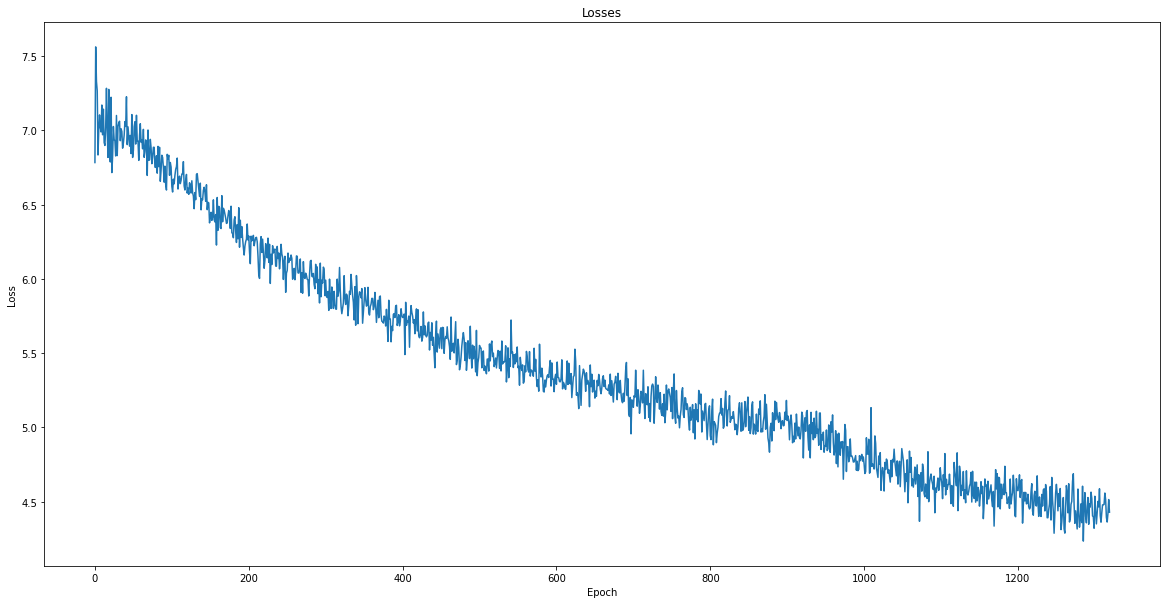

In [ ]:
hidden_size = 300
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

tl = trainIters(encoder, attn_decoder, 120)

In [ ]:
evaluateRandomly(encoder, attn_decoder)

> residents kerala blamed media creating unnecessary panic leading decline tourists visiting state .  in kochi need panic area safe virus .  .  . however media portraying way tourists believe whole kerala affected local tourist guide said . 
= kerala locals blame media tourism falls due nipah
< kerala media media media media sexual assault <EOS>

> finance minister arun jaitley tuesday said assembly elections results bearing 2019 lok sabha polls although bjp leadership cadres pause analyse results take corrective steps .  stating results not expected lines added no one mislead victory defeat one person . 
= bjp take corrective steps 2019 polls jaitley
< bjp polls take 2019 polls jaitley <EOS>

> man maharashtra thane alleged staff odisha jagannath temple snatched gold chain sunday refused pay a huge amount money offering prayers .  victim lodged complaint police alleging priests demanded money name darshan manhandled temple premises . 
= temple staff grab man chain offering lot cash
< 

In [ ]:
evaluate(encoder, attn_decoder, "inaugural laver cup played team europe team world prague .  team includes six players led team captain legend sport .  roger federer rafael nadal team europe play doubles match together team world sam querrey jack sock saturday . ", 90)

(['world', 'team', 'world', 'team', 'world', 'cup', 'team', '<EOS>'],
 tensor([[1.7273e-04, 2.7818e-04, 1.7024e-04, 5.8020e-05, 4.7630e-05, 3.7837e-05,
          1.2337e-04, 9.1638e-05, 7.0810e-05, 2.1190e-04, 5.5196e-04, 1.5158e-04,
          2.6998e-03, 9.8937e-01, 2.8671e-04, 2.8260e-04, 8.0392e-06, 8.9071e-05,
          7.4513e-05, 3.4059e-05, 6.0960e-05, 6.0418e-05, 2.3834e-04, 3.0348e-04,
          2.4462e-04, 2.2475e-04, 1.6435e-04, 4.8172e-05, 2.4105e-04, 6.5701e-05,
          1.8973e-05, 1.0059e-04, 3.7275e-05, 9.3537e-05, 8.6138e-05, 4.5328e-05,
          1.1730e-04, 4.2105e-05, 3.4629e-05, 3.7379e-05, 2.4156e-05, 1.8672e-05,
          1.7115e-05, 1.9117e-05, 2.3321e-05, 1.7842e-05, 3.7720e-05, 2.0876e-05,
          4.2450e-05, 2.8754e-05, 2.7454e-05, 1.6554e-05, 4.0424e-05, 1.0271e-04,
          3.8855e-05, 3.3007e-05, 6.3863e-05, 3.9294e-05, 8.7033e-05, 6.8413e-05,
          6.0509e-05, 5.9096e-05, 1.3019e-04, 4.7689e-05, 5.1459e-05, 7.5659e-05,
          5.0156e-05, 9.3876